c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

device - Stacking Ensemble Accuracy: 0.990625
device - Stacking Ensemble Precision: 0.981337890625
device - Stacking Ensemble Recall: 0.990625
device - Stacking Ensemble f1 score: 0.9859595761381476

Classification Report for device:
                        precision    recall  f1-score   support

Environmental detector       0.00      0.00      0.00         1
        Non IoT-device       0.99      1.00      1.00       317
       Security camera       0.00      0.00      0.00         2

              accuracy                           0.99       320
             macro avg       0.33      0.33      0.33       320
          weighted avg       0.98      0.99      0.99       320



Status - Stacking Ensemble Accuracy: 0.990625
Status - Stacking Ensemble Precision: 0.981337890625
Status - Stacking Ensemble Recall: 0.990625
Status - Stacking Ensemble f1 score: 0.9859595761381476

Classification Report for Status:
               precision    recall  f1-score   support

      Foreign       0.0

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

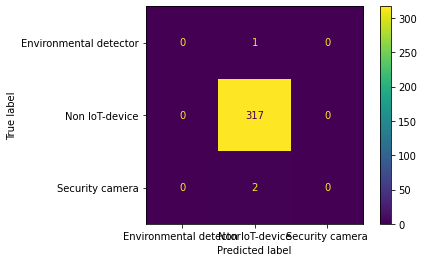

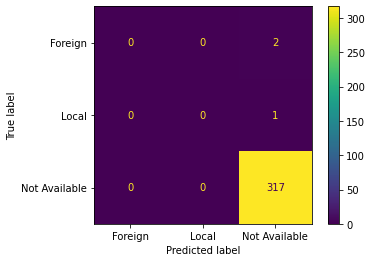

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd


# Load data
data = pd.read_csv('Updated_sample.csv')

# Define features and target columns
features = ['IP address', 'Protocol', 'Packet Size', 'Flow Duration', 'Packets per Second', 'Min Flow Time', 'Mean Flow Time', 'Max Flow Time', 'Communication_Frequency']
target = ['device', 'Status'] 

# Extract features and target from the DataFrame
X = data[features]
y = data[target]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['IP address', 'Protocol'])

# Compute class weights for the target
class_weights_device = compute_class_weight('balanced', classes=np.unique(y['device']), y=y['device'])
class_weights_status = compute_class_weight('balanced', classes=np.unique(y['Status']), y=y['Status'])

# Create a dictionary of class weights for MultiOutputClassifier
class_weights = [{'device': class_weights_device, 'Status': class_weights_status}]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base models
rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced'))
gbm = MultiOutputClassifier(CatBoostClassifier(iterations=100, random_state=42, verbose=0))

# Train base models
rf.fit(X_train, y_train)
gbm.fit(X_train, y_train)

# Generate predictions for the training set (meta-features)
rf_train_preds = np.column_stack([estimator.predict_proba(X_train)[:, 1] for estimator in rf.estimators_])
gbm_train_preds = np.column_stack([estimator.predict_proba(X_train)[:, 1] for estimator in gbm.estimators_])

# Combine predictions as features for the meta-model
meta_features_train = np.hstack((rf_train_preds, gbm_train_preds))

# Train meta-model
meta_model = MultiOutputClassifier(LogisticRegression(random_state=42))
meta_model.fit(meta_features_train, y_train)

# Predictions on the test set
rf_test_preds = np.column_stack([estimator.predict_proba(X_test)[:, 1] for estimator in rf.estimators_])
gbm_test_preds = np.column_stack([estimator.predict_proba(X_test)[:, 1] for estimator in gbm.estimators_])

meta_features_test = np.hstack((rf_test_preds, gbm_test_preds))
final_preds = meta_model.predict(meta_features_test)

# Evaluate each output
for i, col in enumerate(target):
    accuracy = accuracy_score(y_test.iloc[:, i], final_preds[:, i])
    precision = precision_score(y_test.iloc[:, i], final_preds[:, i], average='weighted')
    recall = recall_score(y_test.iloc[:, i], final_preds[:, i], average='weighted')
    f1 = f1_score(y_test.iloc[:, i], final_preds[:, i], average='weighted')

    print(f"{col} - Stacking Ensemble Accuracy: {accuracy}")
    print(f"{col} - Stacking Ensemble Precision: {precision}")
    print(f"{col} - Stacking Ensemble Recall: {recall}")
    print(f"{col} - Stacking Ensemble f1 score: {f1}")
    print()
    print(f"Classification Report for {col}:")
    print(classification_report(y_test[col], final_preds[:, i]))
    print()
    ConfusionMatrixDisplay.from_predictions(y_test.iloc[:, i], final_preds[:, i])
    print()
